# Advanced Lane Finding

In [1]:
# Pipeline
# 1 - calibrate camera
# 2 - distortion correction
# 3 - color and gradient threshold
# 4 - perspective transform
# 5 - locate lines (1 - with histogram, 2 - with convolution)
# 6 - measure curvature

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#%matplotlib qt

In [3]:
def calibrate_camera():
    """
    Calibrate camera with chess board.
    
    Input files were provided and are stored in ./camera_cal/*
    
    Ref.:
    [1] https://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#findChessboardCorners
    [2] https://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#drawchessboardcorners
    [3] http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
    [4] https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html
    """
    w = 9
    h = 6
    
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((h*w, 3), np.float32)
    objp[:, :2] = np.mgrid[0:w, 0:h].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images (there are 20)
    images = glob.glob('./camera_cal/calibration*.jpg')
    
    cmtrx = np.zeros((3, 3))
    cdist = np.zeros((1, 5))
    n = len(images)

    # Step through the list and search for chessboard corners
    for fname in images:
        
        # cv2 read images in BGR color space
        img0 = cv2.imread(fname)
        
        # grayscale
        gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
        shape = gray.shape[::-1]

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (w, h), None)

        # If found, add object points, image points
        if ret == True:
            
            # objpoints are the original "perfect" points in the grid
            objpoints.append(objp)
            
            # increase accuracy
            cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            
            # imgpoints are the same points in the distorted image
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img0, (w, h), corners, ret)
        else:
            print("Nothing found for: " + fname, ret)
    
    # 
    # The for-loop builds the arrays 'objpoints' and 'imgpoints'
    # that are used here to estimate camera coefficients
    #        
    # ret   - True/False
    # mtx   - camera matrix
    # dist  - distortion coefficients
    # rvecs - rotation vectors
    # tvecs - translation vectors
    # 
    r, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    #h0, w0 = img.shape[:2]
    #newmtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w0, h0), 1, (w0, h0))
    return mtx, dist


In [4]:
mtx, dist = calibrate_camera()

Nothing found for: ./camera_cal/calibration5.jpg False
Nothing found for: ./camera_cal/calibration4.jpg False
Nothing found for: ./camera_cal/calibration1.jpg False


In [5]:
def remove_distortion(img):
    return cv2.undistort(img, mtx, dist, None, mtx)


In [6]:
def apply_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """Apply color and Sobel_x (gradient) threshold
    
    Input image is assumed to be RGB.
    It is used the HLS color space and the threshold is applied to the S channel.
    
    Refs.:
    Class 28 https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/d7542ed8-36ce-4407-bd0a-4a38d17d2325
    """

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    
    # Sobel x, Take the derivative in x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    # sobel y
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1)
    
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx) 
    abs_sobely = np.absolute(sobely)
    
    # scale abs_sobelx to the range 0 <=> 255
    scaled_sobel_x = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    scaled_sobel_y = np.uint8(255 * abs_sobely / np.max(abs_sobely))
    
    abs_sobel = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= 30) & (scaled_sobel <= 100)] = 1

    #plt.figure()
    #plt.imshow(mag_binary, cmap='gray')
    #plt.title('magnitude threshold')
    
    # Threshold gradient_x
    gradx = np.zeros_like(scaled_sobel_x)
    gradx[(scaled_sobel_x >= sx_thresh[0]) & (scaled_sobel_x <= sx_thresh[1])] = 1
    
    #plt.figure()
    #plt.imshow(gradx, cmap='gray')
    #plt.title('sobel gradient_x threshold')
    
    # Threshold gradient_y
    #grady = np.zeros_like(scaled_sobel_y)

    dir_binary = np.zeros_like(s_channel)
    abs_sobel = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary[(abs_sobel >= 0.7) & (abs_sobel <= 1.3)] = 1

    #plt.figure()
    #plt.imshow(dir_binary, cmap='gray')
    #plt.title('direction threshold')
    
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    #plt.figure()
    #plt.imshow(s_binary, cmap='gray')
    #plt.title('s channel threshold')

    # 
    # np.zeros_like creates an "image" (actually an rectangular array) with zeros 
    # zero values are seen as black pixels
    # 
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined = np.zeros_like(s_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
    
    #return np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    return combined


In [7]:
def perspective_transform():
    """Perspective transform
    
    Refs.:
    [1] https://discussions.udacity.com/t/perspective-transform/235255/23
    """
    src = np.float32([[(200, 720), (570, 470), (720, 470), (1130, 720)]])
    dst = np.float32([[(350, 720), (350,   0), (980,   0), ( 980, 720)]])
    w,h = 1280,720
    x,y = 0.5*w, 0.8*h
    src = np.float32([[200./1280*w,720./720*h],
                  [453./1280*w,547./720*h],
                  [835./1280*w,547./720*h],
                  [1100./1280*w,720./720*h]])
    dst = np.float32([[(w-x)/2.,h],
                  [(w-x)/2.,0.82*h],
                  [(w+x)/2.,0.82*h],
                  [(w+x)/2.,h]])
    return [cv2.getPerspectiveTransform(src, dst), cv2.getPerspectiveTransform(dst, src)]
    #Compute the inverse perspective transform:
    #Minv = cv2.getPerspectiveTransform(dst, src)
    #Warp an image using the perspective transform, M:
    #warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

M, Minv = perspective_transform()

In [86]:
def camera_top_view(img):
    return cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)

def camera_front_view(img):
    return cv2.warpPerspective(img, Minv, img.shape[1::-1], flags=cv2.INTER_LINEAR)

In [9]:
def calc_curvature(fit, y):
    if fit is None:
        return 0.0
    return (1 + (2*fit[0]*y + fit[1])**2)**1.5 / np.absolute(2 * fit[0])


In [141]:
def ewma(x, alpha):
    '''
    Returns the exponentially weighted moving average of x.

    Parameters:
    -----------
    x : array-like
    alpha : float {0 <= alpha <= 1}

    Returns:
    --------
    ewma : numpy array
        the exponentially weighted moving average
    
    Ref.:
    https://stackoverflow.com/a/42905202
    '''
    # coerce x to an array
    x = np.array(x)
    n = x.size
    s = x.shape
    # create an initial weight matrix of (1-alpha), and a matrix of powers
    # to raise the weights by
    w0 = np.ones(shape=(n,n)) * (1-alpha) 
    p = np.vstack([np.arange(i, i - n, -1) for i in range(n)])
    # create the weight matrix
    w = np.tril(w0**p, 0)
    print(w)
    print(x[::np.newaxis])
    print(w.sum(axis=1))
    print(np.dot(w, x.flatten()))
    # calculate the ewma
    #return np.dot(w, x[::np.newaxis]) / w.sum(axis=1)
    return (np.dot(w, x.flatten()) / w.sum(axis=1))

x = np.array([[2, 3, 4], [2, 3, 4]])
ewma(x, 0.50)

[[ 1.       0.       0.       0.       0.       0.     ]
 [ 0.5      1.       0.       0.       0.       0.     ]
 [ 0.25     0.5      1.       0.       0.       0.     ]
 [ 0.125    0.25     0.5      1.       0.       0.     ]
 [ 0.0625   0.125    0.25     0.5      1.       0.     ]
 [ 0.03125  0.0625   0.125    0.25     0.5      1.     ]]
[[2 3 4]
 [2 3 4]]
[ 1.       1.5      1.75     1.875    1.9375   1.96875]
[ 2.    4.    6.    5.    5.5   6.75]


array([ 2.        ,  2.66666667,  3.42857143,  2.66666667,  2.83870968,
        3.42857143])

In [180]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #
        self.fits = np.empty((0,3), dtype='float') 
        # polynomial coefficients for the most recent fit
        self.current_fit = np.array([0, 0, 0], dtype='float') 
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        
        self.windows = np.empty((0, 8), dtype='int')

        
class Lane():
    
    def __init__(self):
        self.window_height = 0
        self.window_count = 9
        #self.windows = []
        self.vehicle_pos = 0.0
        
        self.right = Line()
        self.left = Line()
        
        self.output_image = None
        self.output_image_file = ''
        
        self.frame_count = 0
        self.margin = 100
        self.minpixel = 30
        self.keep_fit = 30
        self.shape = None
        
        self.input_frame = None
        self.input_image = None
    

    def searchFrame(self, img):
        
        self.frame_count = self.frame_count + 1
        self.input_image = img
        
        # remove camera distortion
        frame = remove_distortion(img)
        
        #plt.figure()
        #plt.imshow(frame)
        #plt.title('distortion removed')

        # apply color and gradient threshold
        frame = apply_threshold(frame)
        
        #plt.figure()
        #plt.imshow(frame, cmap='gray')
        #plt.title('combined threshold')

        # warp image
        binary_warped = camera_top_view(frame)
        
        self.input_frame = binary_warped
        self.shape = binary_warped.shape
        self.window_height = self.shape[0] / self.window_count
        # Take a histogram of the bottom half of the image
        # this 'histogram' var is a numpy 1-D array
        histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)

        # Create an output image to draw on and  visualize the result
        self.output_image = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0] / 2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Identify the x and y positions of all nonzero pixels in the image
        #
        # np.nonzero returns two arrays, first with axis=0 (Y) indices
        #   second with axis=1, (X) indices
        # 
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window (copy)
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        # this 'windows' are horizontal stripes searched
        for window in range(0, self.window_count):

            # Identify window boundaries in x and y (and right and left)
            win_y_low = int(binary_warped.shape[0] - (window + 1) * self.window_height)
            win_y_high = int(binary_warped.shape[0] - window * self.window_height)

            # left line
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin

            # right line
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin
            
            #print(window, 'left ', win_xleft_low,  win_y_low, win_xleft_high,  win_y_low, win_xleft_high,  win_y_high, win_xleft_low,  win_y_high)
            #print(window, 'right', win_xright_low, win_y_low, win_xright_high, win_y_low, win_xright_high, win_y_high, win_xright_low, win_y_high)

            leftp = np.array([[win_xleft_low,  win_y_low, win_xleft_high,  win_y_low, win_xleft_high,  win_y_high, win_xleft_low,  win_y_high]])
            rightp = np.array([[win_xright_low, win_y_low, win_xright_high, win_y_low, win_xright_high, win_y_high, win_xright_low, win_y_high]])
            
            self.left.windows = np.concatenate((self.left.windows, leftp))
            self.right.windows = np.concatenate((self.right.windows, rightp))
            
            # ==========
            # Find Lines
            # ==========

            # left line
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

            # right line
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            #print(nonzerox.shape, nonzeroy.shape)
            #print('good_left_inds ', good_left_inds)
            #print('good_right_inds', good_right_inds)
            
            # 
            # Append these indices to the lists
            # appends points from all windows
            # 
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            
            # =========================
            # Update Left_X and Right_X
            # =========================
            
            y = (win_y_high - win_y_low) / 2

            # first image will NOT use polyfit
            if self.frame_count == 1:
                if len(good_left_inds) > self.minpixel:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                else:
                    #print('good left', good_left_inds)
                    pass
                
                if len(good_right_inds) > self.minpixel:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                else:
                    #print('good right', good_right_inds)
                    pass
                    
            else:
                # select a new stripe and search for peaks in histogram
                stripe = np.sum(binary_warped[win_y_low:win_y_high, :], axis=0)
                
                #stripel = np.sum(binary_warped[win_y_low:win_y_high, win_xleft_low:win_xleft_high], axis=0)
                #striper = np.sum(binary_warped[win_y_low:win_y_high, win_xright_low:win_xright_high], axis=0)
                
                midpoint = np.int(stripe.shape[0] / 2)
                #leftx_base = np.argmax(stripe[:midpoint])
                #rightx_base = np.argmax(stripe[midpoint:]) + midpoint

                if len(good_left_inds) > self.minpixel:
                    #leftx_current = self.left.current_fit[0] * y**2 + self.left.current_fit[1]*y + self.left.current_fit[2]
                    leftx_current = np.dot(self.left.current_fit, [y**2, y, 1])
                else:
                    #print('good left', good_left_inds)
                    #leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                    leftx_current = np.argmax(stripe[:midpoint])
                    #leftx_current = np.argmax(stripel[:midpoint])

                if len(good_right_inds) > self.minpixel:        
                    #rightx_current = self.right.current_fit[0] * y**2 + self.right.current_fit[1]*y + self.right.current_fit[2]   
                    rightx_current = np.dot(self.right.current_fit, [y**2, y, 1])
                else:
                    #print('good right', good_right_inds)
                    #rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                    rightx_current = np.argmax(stripe[midpoint:]) + midpoint
                    #rightx_current = np.argmax(striper[midpoint:]) + midpoint
                
            #print(window, 'good left pixels ', len(good_left_inds))
            #print(window, 'good right pixels', len(good_right_inds))

        # Concatenate the arrays of indices
        #print(left_lane_inds)
        left_lane_inds = np.concatenate(left_lane_inds)
        #print(right_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        self.left.allx = nonzerox[(left_lane_inds)]
        self.left.ally = nonzeroy[(left_lane_inds)]
        
        self.right.allx = nonzerox[(right_lane_inds)]
        self.right.ally = nonzeroy[(right_lane_inds)]
        
        if len(leftx) == 0 or len(lefty) == 0:
            # if not detected, keep last fit?
            self.left.detected = False
            print('left line not detected for frame ', self.frame_count)
            plt.imsave('./output_images/trouble_frame{:5d}_left.png'.format(self.frame_count), img)
        else:
            self.left.detected = True
            left_fit = np.array([np.polyfit(lefty, leftx, 2)])
            self.left.diffs
            self.left.fits = np.concatenate((self.left.fits, left_fit), axis=0)
            #self.left.fits.append(left_fit)
            if len(self.left.fits) > self.keep_fit:
                # keep only last 'self.keep_fit' frame
                self.left.fits = self.left.fits[-self.keep_fit:]

            self.left.current_fit = left_fit[0]
            self.left.best_fit = np.mean(self.left.fits, axis=0, dtype=np.float64)
            #self.left.best_fit = ewma(self.left.fits, 0.75)
            #print('left shape', self.left.fits.shape)
            #print('fits', self.left.fits)
        #print('left best fit', self.left.best_fit)
        
        if len(rightx) == 0 or len(righty) == 0:
            self.right.detected = False
            print('right line not detected')
            plt.imsave('./output_images/trouble_frame{:5d}_right.png'.format(self.frame_count), img)
        else:
            self.right.detected = True
            right_fit = np.array([np.polyfit(righty, rightx, 2)])
            self.right.diffs
            self.right.fits = np.concatenate((self.right.fits, right_fit), axis=0)
            if len(self.right.fits) > self.keep_fit:
                # keep only last 'self.keep_fi' frame
                self.right.fits = self.right.fits[-self.keep_fit:]
            #
            self.right.current_fit = right_fit[0]
            self.right.best_fit = np.mean(self.right.fits, axis=0, dtype=np.float64)
            #self.right.best_fit = ewma(self.right.fits, 0.75)
        #print('right best fit', self.right.best_fit)

        # Fit a second order polynomial to each
        # 
        # np.polyfit (2) returns: coefficients A, B, C for x = Ayˆ2 + By + C
        #  as the we have a function of y, not x.
        # 
        self.left.radius_of_curvature = calc_curvature(self.left.best_fit, self.shape[0])
        self.right.radius_of_curvature = calc_curvature(self.right.best_fit, self.shape[0])
        
        # Ay**2 + By + C
        lx = np.dot(self.left.best_fit,  [self.shape[0]*self.shape[0], self.shape[0], 1])
        rx = np.dot(self.right.best_fit, [self.shape[0]*self.shape[0], self.shape[0], 1])
        
        lanewidth = rx - lx
        lanecenter = (lx + rx) / 2
        imgcenter = self.shape[1]/2
        self.vehicle_pos = (lanecenter - imgcenter) * 3.7 / lanewidth
        p = (lanecenter - imgcenter) * 3.7 / lanewidth
        c = (self.left.radius_of_curvature + self.right.radius_of_curvature)/2
        
        #print(self.frame_count, self.left.current_fit, self.right.current_fit)
        
        
        ploty = np.linspace(0, self.shape[0] - 1, self.shape[0] )
        
        left_fit = self.left.best_fit
        if left_fit is not None:
            left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        else:
            left_fitx = np.zeros_like(ploty)
        
        right_fit = self.right.best_fit
        if right_fit is not None:
            right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
        else:
            right_fitx = np.zeros_like(ploty)        
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(self.input_frame).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (self.input_frame.shape[1], self.input_frame.shape[0])) 
        
        cv2.putText(self.input_image, "Vehicle offset {: 3.1f}m".format(p), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3)
        cv2.putText(self.input_image, "Curvature {: 7.0f}m".format(c), (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3)

        # Combine the result with the original image
        result = cv2.addWeighted(self.input_image, 1, newwarp, 0.3, 0)        
        
        return result
        
        
    def searchFile(self, filename):
        # read input image
        img = mpimg.imread(filename)
        
        #plt.figure()
        #plt.imshow(warped, cmap='gray')
        #plt.title('warped')

        #fit
        return self.searchFrame(img)
        
    def plot(self):
        
        if self.input_frame is None:
            return False
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, self.shape[0] - 1, self.shape[0] )
        
        left_fit = self.left.best_fit
        if left_fit is not None:
            left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        else:
            left_fitx = np.zeros_like(ploty)
        
        right_fit = self.right.best_fit
        if right_fit is not None:
            right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
        else:
            right_fitx = np.zeros_like(ploty)
        
        # Create an image to draw on and an image to show the selection window
        self.output_image = np.dstack((self.input_frame, self.input_frame, self.input_frame)) * 255
        window_img = np.zeros_like(self.output_image)
        window_img2 = np.copy(self.output_image)

        # Color in left and right line pixels
        self.output_image[self.left.ally,  self.left.allx ] = [255, 0, 0]
        self.output_image[self.right.ally, self.right.allx] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - self.margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + self.margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - self.margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + self.margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
        # square windows
        #cv2.fillPoly(window_img, np.int_(self.right.windows), (0, 255, 0))
        for wd in self.left.windows:
            w = np.int_(wd)
            p1 = (w[0], w[1])
            p2 = (w[4], w[5])
            #print('p1', p1, 'p2', p2)
            cv2.rectangle(window_img, p1, p2, (255, 255, 0), 4)
            #cv2.rectangle(window_img2, p1, p2, (255, 255, 0), 4)

        for wd in self.right.windows:
            w = np.int_(wd)
            p1 = (w[0], w[1])
            p2 = (w[4], w[5])
            #print('p1', p1, 'p2', p2)
            cv2.rectangle(window_img, p1, p2, (255, 255, 0), 4)
            #cv2.rectangle(window_img2, p1, p2, (255, 255, 0), 4)
        
        #cv2.rectangle(window_img2, (100, 100), (700, 600), (250, 250, 250))
        #plt.figure()
        #plt.imshow(window_img2, cmap='gray')
        
        r1 = self.left.radius_of_curvature
        r2 = self.right.radius_of_curvature 

        #r1 = calc_curvature(leftfit, warped.shape[0])
        #r2 = calc_curvature(rightfit, warped.shape[0])

        print('Curvature: {: 7.0f}, car offset: {:7.3f}'.format((r1+r2)/2, 0))
        

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
        result = cv2.addWeighted(self.output_image, 1, window_img, 0.3, 0)
        
        plt.figure()
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.title('poly fit')

        plt.figure()
        plt.title('projection')
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(self.input_frame).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (self.input_frame.shape[1], self.input_frame.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(self.input_image, 1, newwarp, 0.3, 0)
        plt.imshow(result)

In [11]:
def pipeline(frame):
    
    frame = remove_distortion(frame)
    plt.figure()
    plt.imshow(frame)
    plt.title('distortion removed')
    
    frame = apply_threshold(frame)
    plt.figure()
    plt.imshow(frame, cmap='gray')
    plt.title('combined threshold')
    
    warped = camera_top_view(frame)
    plt.figure()
    plt.imshow(warped, cmap='gray')
    plt.title('warped')
    
    
    #leftfit = poly_fit(warped)
    obj = Lane()
    obj.searchFrame(warped)
    obj.plot()
    
    leftfit = obj.left.best_fit
    rightfit = obj.right.best_fit
    
    r1 = obj.left.radius_of_curvature
    r2 = obj.right.radius_of_curvature 
    
    #r1 = calc_curvature(leftfit, warped.shape[0])
    #r2 = calc_curvature(rightfit, warped.shape[0])
    
    print('Curvature: {: 7.3f}, car offset: {:7.3f}'.format((r1+r2)/2, 0))

# Exec

In [ ]:
plt.figure()
plt.imshow(cv2.undistort(cv2.imread("./camera_cal/calibration1.jpg"), mtx, dist, None, mtx))

Checking ./test_images/test7.jpg
Curvature:    2965, car offset:   0.000


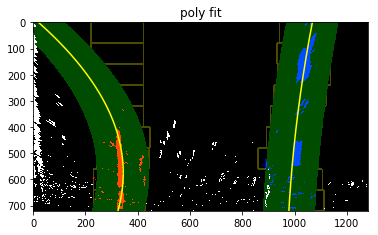

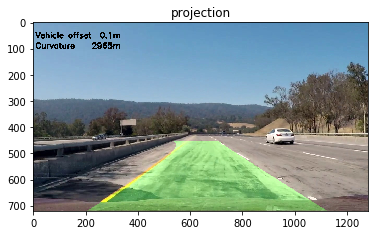

In [184]:
#images = glob.glob('./test_images/*.jpg')
#images = ['./test_images/straight_lines2.jpg']
images = ['./test_images/test7.jpg']

for fname in images:
    print('Checking ' + fname)
    print('=' * 50)
    
    #img = cv2.imread(fname)
    #img = mpimg.imread(fname)
    #pipeline(img)
    obj = Lane()
    obj.searchFile(fname)
    obj.plot()
    
    


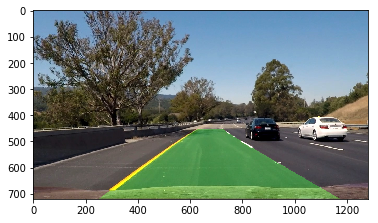

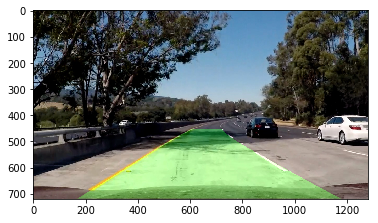

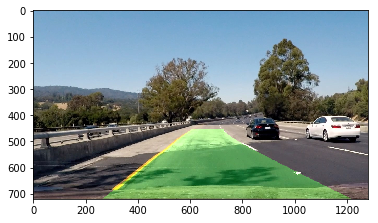

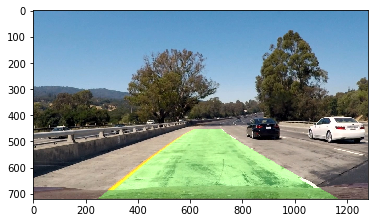

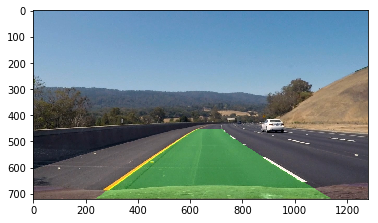

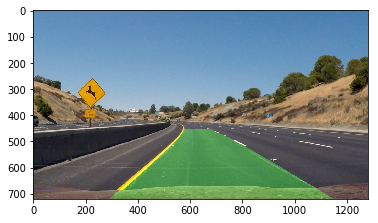

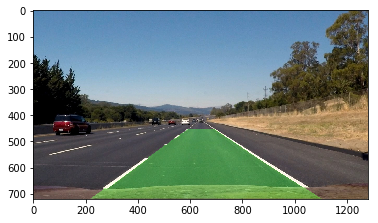

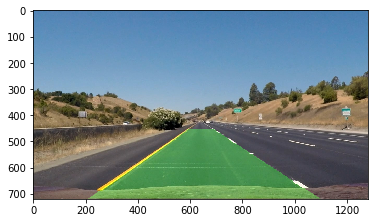

In [111]:
images = glob.glob('./test_images/*.jpg')
#images = ['./test_images/straight_lines2.jpg']

for fname in images:
    obj = Lane()
    img = obj.searchFile(fname)
    plt.figure()
    plt.imshow(img)
    #obj.plot()

In [100]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [181]:
white_output = "./project_video_projection_sub.mp4"
#clip1 = VideoFileClip("./project_video.mp4")
#clip1 = VideoFileClip("./project_video.mp4").subclip(0, 2)
clip1 = VideoFileClip("./project_video.mp4").subclip(21, 24)
#clip1.without_audio()

obj = Lane()
white_clip = clip1.fl_image(obj.searchFrame)

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video_projection_sub.mp4
[MoviePy] Writing video ./project_video_projection_sub.mp4



 99%|█████████▊| 75/76 [00:13<00:00,  4.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_projection_sub.mp4 

CPU times: user 23.2 s, sys: 3.13 s, total: 26.3 s
Wall time: 15.9 s


In [175]:
%%HTML
<video width="320" height="240" controls>
  <source src="./project_video_projection.mp4" type="video/mp4">
</video>